# Chapter 7

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch07-nonlin-lab-zh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/phonchi/nsysu-math524/blob/main/static_files/presentations/Ch07-nonlin-lab-zh.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>


In [ ]:
%load_ext cudf.pandas
%load_ext cuml.accel

In [2]:
%pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 15.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=af995aa8398d0564852d7d684416e62c1e8099295baae81f824d8d6d55d84d43
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


我們必須重新啟動執行環境以使用新安裝的版本！

In [1]:
# 本 Notebook 使用的匯入（imports）
import numpy as np  # 數值運算與陣列處理
import pandas as pd  # 資料表格與資料處理
import seaborn as sns  # 統計視覺化
import matplotlib.pyplot as plt  # 繪圖指令與樣式
from matplotlib.pyplot import subplots  # 建立子圖與繪圖版面
import statsmodels.api as sm  # 統計模型與推論
from statsmodels.stats.anova import anova_lm  # ANOVA 檢定
from sklearn.preprocessing import SplineTransformer  # sklearn 样條特徵轉換
from ISLP import load_data  # ISLP 資料載入
from ISLP.models import (
    summarize, bs, ns, ModelSpec as MS, poly
)  # ISLP 模型輔助：摘要、樣條基底、多項式與模型規格
from ISLP.transforms import (BSpline,
                NaturalSpline)
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

# 實驗：非線性建模

在本實驗中，我們示範本章討論的一些非線性模型。我們使用 [`Wage`](https://islp.readthedocs.io/en/latest/datasets/Wage.html) 資料作為執行範例，並展示許多討論的複雜非線性擬合程序可以在 Python 中輕鬆實作。

如往常一樣，我們從一些標準 imports 開始。

In [2]:
%matplotlib inline

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## 多項式回歸與步階函數

我們首先示範如何重現圖 7.1。讓我們從載入資料開始。

In [3]:
Wage = load_data('Wage')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
y = Wage['wage']
age = Wage['age']

在這個實驗的大部分時間裡，我們的回應變數是 `Wage['wage']`，已儲存為上面的 `y`。

如同第 3.6.6 節，我們將使用 `poly()` 函數來建立一個模型矩陣，該矩陣將擬合 `age` 的 4 次多項式。

In [5]:
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


這個多項式是使用 [`poly()`](https://islp.readthedocs.io/en/latest/transforms/poly.html#) 函數建構的，該函數建立了一個特殊的*轉換器* [`Poly()`](https://islp.readthedocs.io/en/latest/api/generated/ISLP.transforms.html#poly)（使用 `scikit-learn` 對特徵轉換的術語，如第 6.5.3 節中看到的 `PCA()`），這樣可以在新資料點上輕鬆評估多項式。這裡 `poly()` 稱為*輔助*函數，並設定轉換；`Poly()` 是執行轉換的實際工作元件。

在上面的程式碼中，第一行使用 dataframe `Wage` 執行 `fit()` 方法。這會重新計算並儲存 `Poly()` 在訓練資料上所需的任何參數作為屬性，這些參數將用於所有後續的 `transform()` 方法評估。例如，它在第二行中使用，以及在下面開發的繪圖函數中使用。

我們現在為 `age` 建立一個值的格點，在這些值上我們想要進行預測。

In [6]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})

最後，我們希望繪製資料，並加入**四次**多項式的擬合結果。由於我們將在下面製作幾個類似的圖，我們首先編寫一個函數來建立所有成分並產生圖形。我們的函數接受模型規格（這裡是由轉換指定的基底），以及 `age` 值的格點。該函數產生擬合曲線以及 95% 信賴區間帶。通過使用 `basis` 引數，我們可以使用不同的轉換來產生和繪製結果，比如我們很快會看到的樣條。

In [7]:
def plot_wage_fit(age_df,
                  basis,
                  title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,
               y,
               facecolor='gray',
               alpha=0.5)
    for val, ls in zip([preds.predicted_mean,
                      bands[:,0],
                      bands[:,1]],
                     ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

我們在 `ax.scatter()` 中包含了 `alpha` 參數來為點增加一些透明度。這提供了密度的視覺指示。注意在上面的 `for` 迴圈中使用 `zip()` 函數（參見第 2.3.8 節）。

我們要繪製三條線，每條都有不同的顏色和線型。這裡 `zip()` 方便地將它們捆綁在一起作為迴圈中的迭代器。在 Python 術語中，「迭代器」是一個有有限數值的物件，可以在迴圈中進行迭代。

我們現在使用這個函數繪製四次多項式的擬合結果。

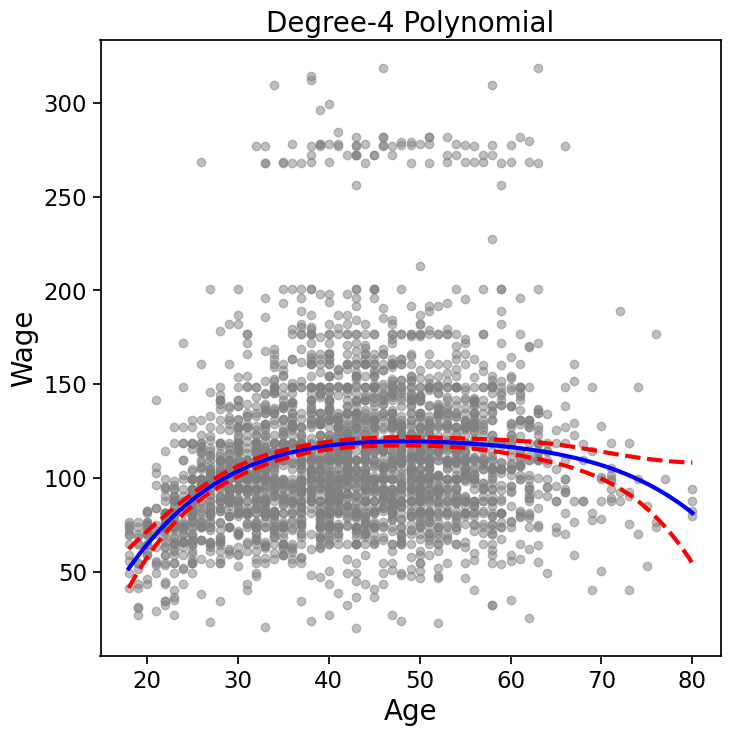

In [8]:
plot_wage_fit(age_df,
              poly_age,
              'Degree-4 Polynomial');

如果你的目標純粹是視覺化，那麼你可以簡單地使用 `seaborn` 套件

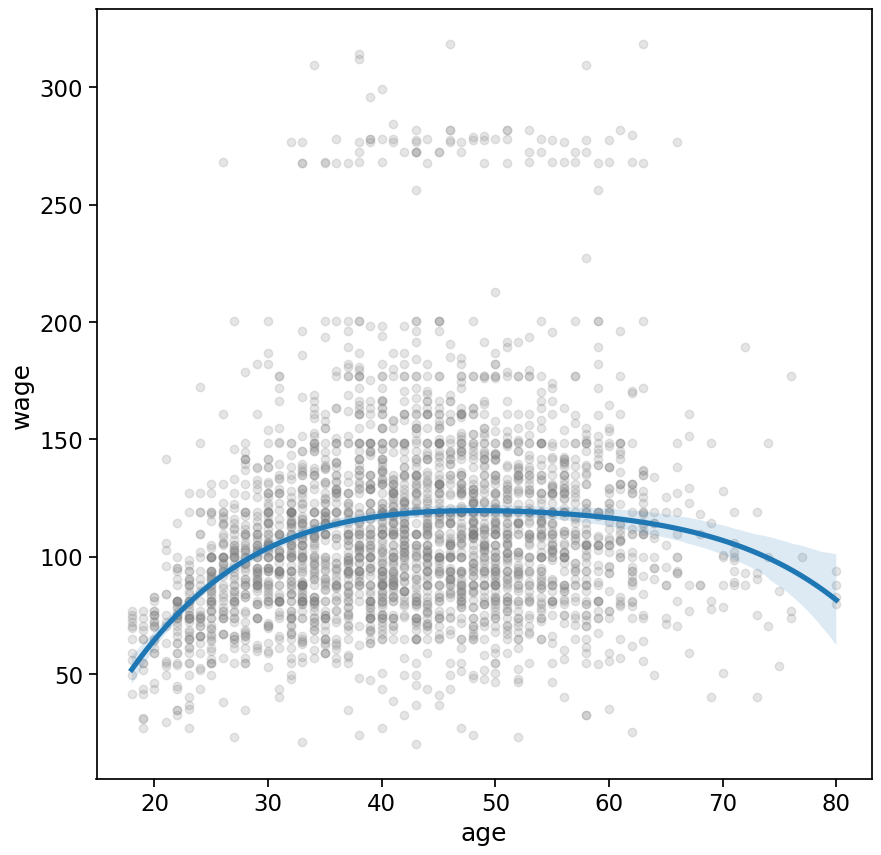

In [9]:
# 使用 seaborn 輕鬆繪製高階多項式迴歸
plt.figure(figsize=(10,10))
sns.regplot(x='age', y='wage', data=Wage, order=4,
            scatter_kws={'alpha': 0.2, 'color': 'gray', 'facecolor': None});

你也可以嘗試使用 bootstrap 方法 [https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot](https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot)。

對於多項式迴歸，我們必須決定要使用的多項式次數。有時我們只是臨機決定，決定使用二次或三次多項式，只是為了獲得非線性擬合。但我們可以用更系統化的方式來做這個決定。一種方法是通過假設檢定，我們在這裡示範。我們現在擬合一系列從線性（一次）到五次多項式的模型，並尋求確定足以解釋 `wage` 和 `age` 之間關係的最簡單模型。我們使用 `anova_lm()` 函數，它執行一系列 ANOVA 檢定。

變異數分析或 ANOVA 檢定的**虛無假設是模型 $\mathcal{M}_1$ 足以解釋資料，對應的對立假設是需要更複雜的模型 $\mathcal{M}_2$**。決定是基於 F 檢定。為了執行檢定，模型 $\mathcal{M}_1$ 和 $\mathcal{M}_2$ 必須是*巢狀的*：$\mathcal{M}_1$ 中預測變數所跨越的空間必須是 $\mathcal{M}_2$ 中預測變數所跨越空間的子空間。在這種情況下，我們擬合五個不同的多項式模型，並順序地比較較簡單的模型與較複雜的模型。

In [10]:
models = [MS([poly('age', degree=d)])
          for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


注意上面 `anova_lm()` 行中的 `*`。這個函數接受可變數目的非關鍵字參數，在這種情況下是擬合的模型。當這些模型以列表形式提供時（如此處所做），它必須前面加上 `*`。

比較線性 `models[0]` 與二次 `models[1]` 的 p 值基本上是零，表明線性擬合是不夠的。從零開始的索引對於多項式次數範例來說令人困惑，因為 `models[1]` 是二次的而不是線性的！同樣，比較二次 `models[1]` 與三次 `models[2]` 的 p 值非常低（0.0017），所以二次擬合也是不夠的。比較三次和四次多項式 `models[2]` 和 `models[3]` 的 p 值約為 5%，而五次多項式 `models[4]` 似乎沒有必要，因為它的 p 值是 0.37。因此，三次或四次多項式似乎對資料提供了合理的擬合，但更低或更高次數的模型是不合理的。

在這種情況下，我們可以不使用 `anova()` 函數，而利用 `poly()` 創建正交多項式的事實更簡潔地獲得這些 p 值。

注意 p 值是相同的，實際上 t 統計量的平方等於 `anova_lm()` 函數的 F 統計量；例如：

In [11]:
(-11.983)**2

143.59228900000002

然而，只要我們使用巢狀模型，ANOVA 方法無論我們是否使用正交多項式都能運作。例如，我們可以使用 `anova_lm()` 比較以下三個模型，它們都在 `education` 中有線性項和不同次數的 `age` 多項式：

In [12]:
models = [MS(['education', poly('age', degree=d)])
          for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


作為使用假設檢定和 ANOVA 的替代方案，我們可以使用如第 5 章討論的交叉驗證來選擇多項式次數。

接下來我們考慮預測個人是否年收入超過 $250,000 的任務。我們的處理方法與之前大致相同，只是首先我們建立了適當的回應向量，然後使用二項式族應用 `glm()` 函數，以擬合多項式邏輯迴歸模型。

In [13]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y > 250 # shorthand
glm = sm.GLM(y > 250,
             X,
             family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


我們再次使用 `get_prediction()` 方法進行預測。

In [14]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

我們現在繪製估計的關係。

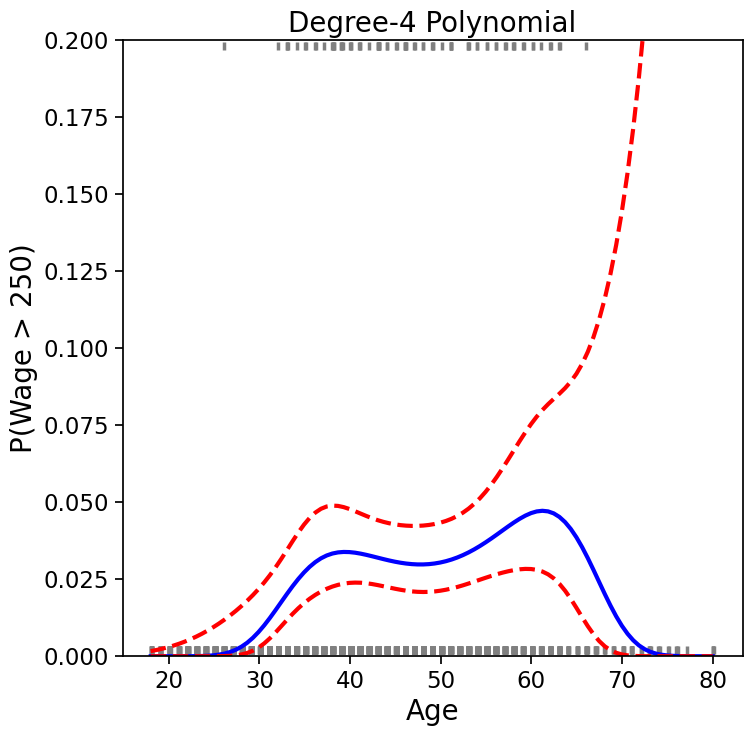

In [15]:
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean,
                  bands[:,0],
                  bands[:,1]],
                 ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

我們將對應於 `wage` 值高於 250 的觀測的 `age` 值繪製為圖頂部的灰色標記，而 `wage` 值低於 250 的觀測則顯示為圖底部的灰色標記。我們為 `age` 值添加了少量的雜訊抖動，使得相同 `age` 值的觀測不會相互遮蓋。這種類型的圖通常稱為*地毯圖*。

為了擬合步階函數（如第 7.2 節討論），我們首先使用 `pd.qcut()` 函數根據分位數將 `age` 離散化。然後我們使用 `pd.get_dummies()` 為這個類別變數建立模型矩陣的欄位。注意：這個函數將包含給定類別的*所有*欄位，而不是通常丟棄其中一個層級的方法。

In [16]:
cut_age = pd.qcut(age, 4)
X_cut = pd.get_dummies(cut_age)
model = sm.OLS(y, X_cut).fit()
summarize(model)

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


這裡 `pd.qcut()` 根據 25%、50% 和 75% 的分位數自動選擇了切分點，這導致了四個區域。我們也可以直接指定自己的分位數，而不是參數 `4`。對於不基於分位數的切分，我們會使用 `pd.cut()` 函數。

函數 `pd.qcut()`（以及 `pd.cut()`）回傳一個有序的類別變數。然後迴歸模型為迴歸使用建立一組虛擬變數。由於 `age` 是模型中唯一的變數，值 $94,158.40 是 33.75 歲以下人群的平均薪資，其他係數是其他年齡群組的平均薪資。我們可以像多項式擬合的情況一樣產生預測和繪圖。

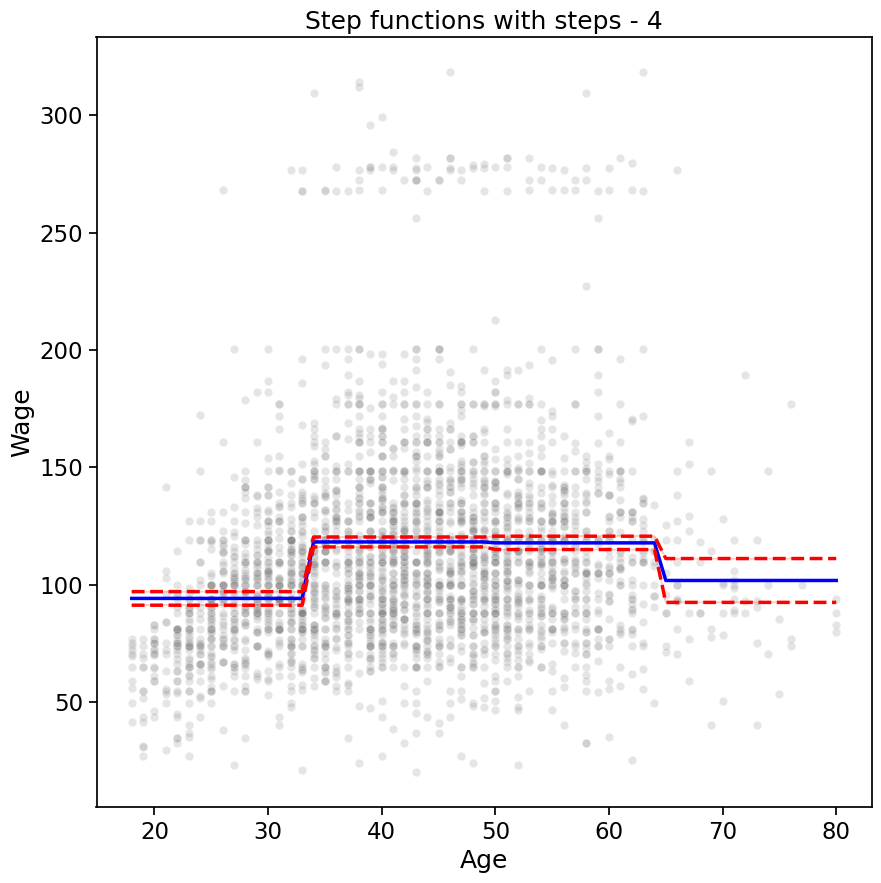

In [17]:
cut_age = pd.cut(age, 4) #cut instead of qcut
X_cut = pd.get_dummies(cut_age)
model = sm.OLS(y, X_cut).fit()
pred_step = model.predict(X_cut)
predictions = model.get_prediction()
df_predictions = predictions.summary_frame()

fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)
sns.lineplot(x=Wage['age'],y=pred_step, ax=ax, color='blue')

plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Step functions with steps - 4')

# 繪圖 confidence intervals
#plt.fill_between(df_預測s.index, df_預測s.obs_ci_lower, df_預測s.obs_ci_upper, alpha=.1, color='crimson')
sns.lineplot(x=age, y=df_predictions.mean_ci_lower, color='red')
sns.lineplot(x=age, y=df_predictions.mean_ci_upper, color='red')
# dash confidnece int
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--");

## 樣條

為了擬合迴歸樣條，我們使用來自 `ISLP` 套件的轉換器。實際的樣條評估函數在 [`scipy.interpolate`](https://docs.scipy.org/doc/scipy/reference/interpolate.html) 套件中；我們只是將它們包裝成類似於 `Poly()` 和 `PCA()` 的轉換器。

在第 7.4 節中，我們看到迴歸樣條可以通過建構適當的基底函數矩陣來擬合。[`BSpline()`](https://islp.readthedocs.io/en/latest/api/generated/ISLP.transforms.html#bspline) 函數為指定節點集合的樣條產生整個基底函數矩陣。預設情況下，產生的 B-樣條是三次的。要改變次數，使用 `degree` 參數。

In [18]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

這產生了一個七欄矩陣，這是三次樣條基底配 3 個內部節點所預期的結果。

我們可以使用 [`bs()`](https://islp.readthedocs.io/en/latest/transforms/splines.html) 物件形成相同的矩陣，它便於將其添加到模型矩陣建構器中（如第 7.8.1 節中描述的 `poly()` 對比其工作元件 `Poly()`）。`bs()` 實際上是來自 `pasty.dmatrix` 的回歸樣條 - [https://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression](https://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression)。

我們現在為 `Wage` 資料擬合三次樣條模型。

In [19]:
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


欄名有些冗長，導致我們需要截斷列印的摘要。可以在建構時使用 `name` 參數來設定它們，如下所示：

In [20]:
bs_age = MS([bs('age',
                internal_knots=[25,40,60],
                name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


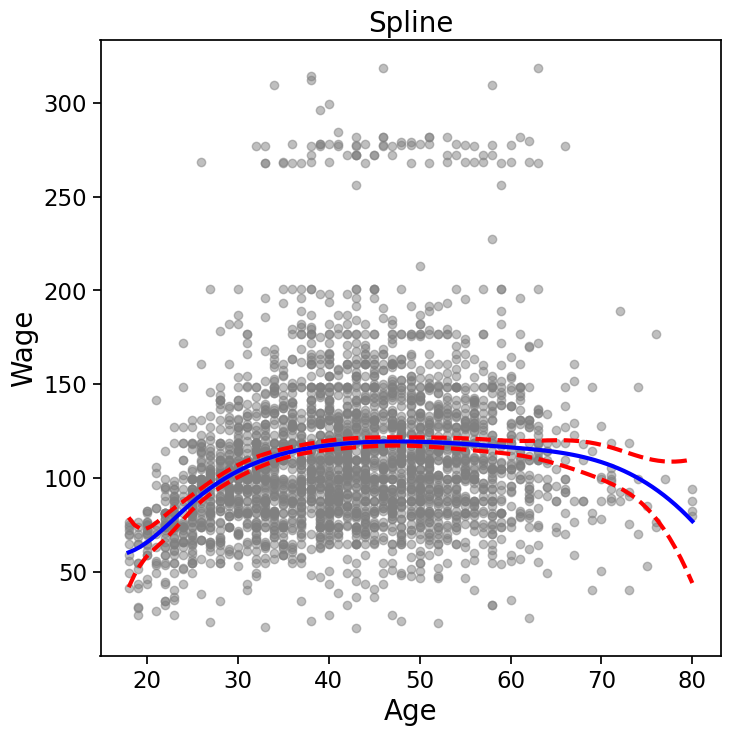

In [21]:
plot_wage_fit(age_df,
              bs_age,
              'Spline');

注意有 6 個樣條係數而不是 7 個。這是因為，預設情況下，`bs()` 假設 `intercept=False`，因為我們通常在模型中有一個整體截距項。所以它產生給定節點的樣條基底，然後丟棄一個基底函數以解決截距項的問題。

我們也可以使用 `df`（自由度）選項來指定樣條的複雜度。我們在上面看到，對於 3 個節點，樣條基底有 6 欄或自由度。當我們指定 `df=6` 而不是實際節點時，`bs()` 將產生一個在訓練資料的均勻分位數選擇的 3 個節點的樣條。我們可以最容易地直接使用 `Bspline()` 看到這些選擇的節點：

In [22]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

當要求六個自由度時，轉換器選擇年齡 33.75、42.0 和 51.0 處的節點，這對應於 `age` 的第 25、50 和 75 百分位數。

使用 B-樣條時，我們不需要限制自己使用三次多項式（即 `degree=3`）。例如，使用 `degree=0` 會導致分段常數函數，就像我們上面的 `pd.qcut()` 範例一樣。

In [23]:
bs_age0 = MS([bs('age',
                 df=3,
                 degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


這個擬合應該與我們使用 `qcut()` 透過在 25%、50% 和 75% 分位數的 `age` 處切分來建立四個區間的情況進行比較。由於我們在這裡為零次樣條指定了 `df=3`，在相同的三個分位數處也會有節點。儘管係數看起來不同，我們看到這是不同編碼的結果。例如，第一個係數在兩種情況下都是相同的，是第一個區間的平均回應。對於第二個係數，我們有 $94.158 + 22.349 = 116.507 \approx 116.611$，後者是之前 cell 中第二個區間的平均值。這裡截距項由一欄一來編碼，所以第二、三和四個係數是那些區間的增量。為什麼總和不完全相同？原來 `qcut()` 在決定區間成員資格時使用 $\leq$，而 `bs()` 使用 $<$。

為了擬合自然樣條，我們使用 [`NaturalSpline()`](https://islp.readthedocs.io/en/latest/api/generated/ISLP.transforms.html#naturalspline) 轉換器與相應的輔助函數 `ns()`。這裡我們擬合具有五個自由度（不包括截距）的自然樣條並繪製結果。

In [24]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


我們現在使用我們的繪圖函數繪製自然樣條。

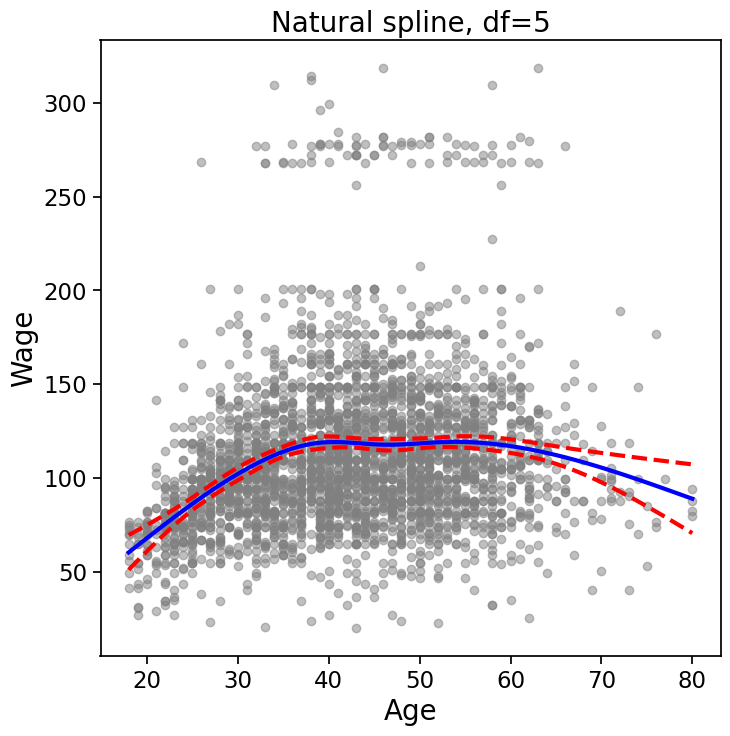

In [25]:
plot_wage_fit(age_df,
              ns_age,
              'Natural spline, df=5');

## B-spline

樣條相對於多項式的一些優點是：

- 如果你保持固定的低次數（通常是3），並且節約地調整節點數目，B-樣條非常靈活和穩健。多項式需要更高的次數，這導致下一點。

- B-樣條在邊界處不像多項式那樣有振盪行為（次數越高，越糟糕）。這被稱為 Runge 現象。

- B-樣條為超越邊界的外推提供了良好的選項，即超越擬合值的範圍。看看外推選項。

- B-樣條產生具有帶狀結構的特徵矩陣。對於單個特徵，每一行僅包含 `degree + 1` 個非零元素，這些元素連續出現且甚至是正數。這導致矩陣具有良好的數值性質，例如低條件數，與多項式矩陣形成鮮明對比，後者被稱為 Vandermonde 矩陣。低條件數對線性模型的穩定算法很重要。

在這裡，我們將示範如何在不使用 ISLP 的情況下使用 scikit-learn 的 [`SplineTransformer()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html)。

In [26]:
# B-spline with 4 + 3 - 1 = 6 basis functions
spline = SplineTransformer(n_knots=4, degree=3)
X = spline.fit_transform(Wage['age'].to_frame())
y = Wage['wage']

model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.55
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           2.41e-56
Time:                        04:43:15   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -114.1421     60.244     -1.895      0.0

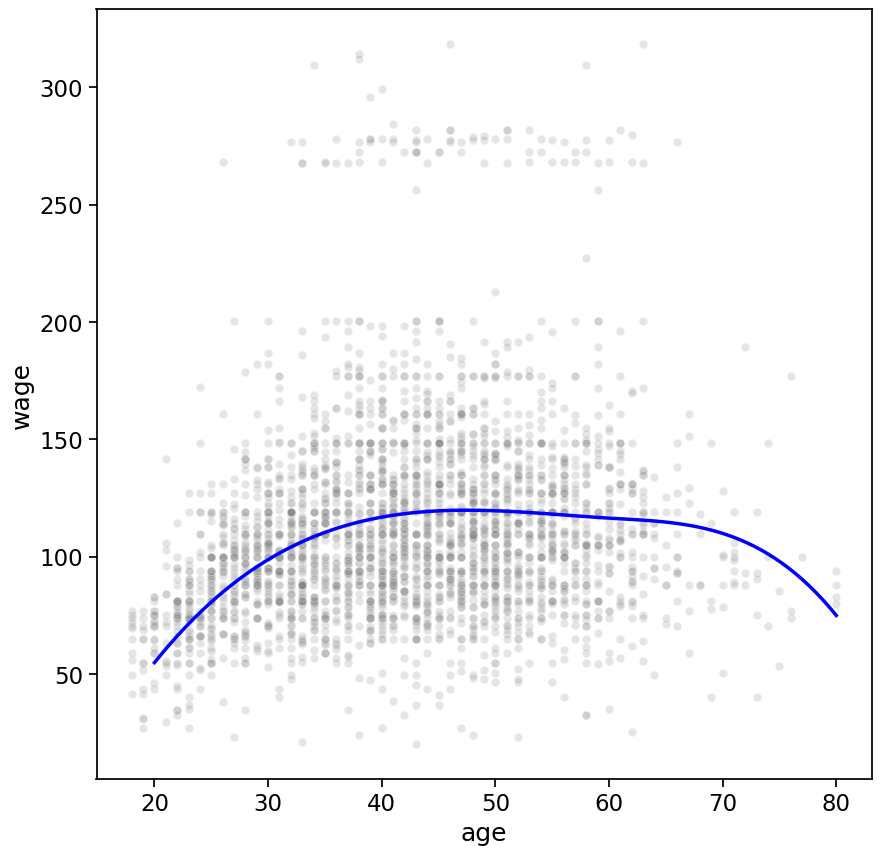

In [27]:
test_ages = np.linspace(20,80,100)
X_test = spline.fit_transform(test_ages.reshape(-1,1))
y_hat = model.predict(X_test)


fig, ax = plt.subplots(figsize=(10,10))

# 繪圖 datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=Wage)

# 繪圖 estimated f(x)
sns.lineplot(x=test_ages, y=y_hat, ax=ax, color='blue');

## 平滑樣條與 GAMs

平滑樣條是具有平方誤差損失和單一特徵的 GAM 的特殊情況。在 Python 中擬合 GAM 我們將使用 [`pygam`](https://pygam.readthedocs.io/en/latest/) 套件，可以通過 `pip install pygam` 安裝。

估計器 `LinearGAM()` 使用平方誤差損失。GAM 通過將模型矩陣的每一欄與特定的平滑操作關聯來指定：[`s`](https://pygam.readthedocs.io/en/latest/api/api.html#spline-term) 用於平滑樣條；[`l`](https://pygam.readthedocs.io/en/latest/api/api.html#linear-term) 用於線性，[`f`](https://pygam.readthedocs.io/en/latest/api/api.html#factor-term) 用於因子或類別變數。

下面傳遞給 `s` 的參數 `0` 表示這個平滑器將應用於特徵矩陣的第一欄。下面，我們傳遞它一個只有單一欄的矩陣：`X_age`。參數 `lam` 是第 7.5.2 節討論的懲罰參數 $\lambda$。

In [28]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

`pygam` 函式庫通常預期接收一個特徵矩陣，因此我們將 `age` 重新塑造為矩陣（二維陣列）而不是向量（即一維陣列）。在 `reshape()` 方法調用中的 `-1` 告訴 `numpy` 根據剩餘條目形狀元組推斷該維度的大小。

讓我們研究擬合如何隨平滑參數 `lam` 變化。函數 `np.logspace()` 與 `np.linspace()` 類似，但在對數尺度上均勻分佈點。下面我們將 `lam` 從 $10^{-2}$ 變化到 $10^6$。

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1922035019.py:11: SyntaxWarning: invalid escape sequence '\l'
  ax.legend(title='$\lambda$');


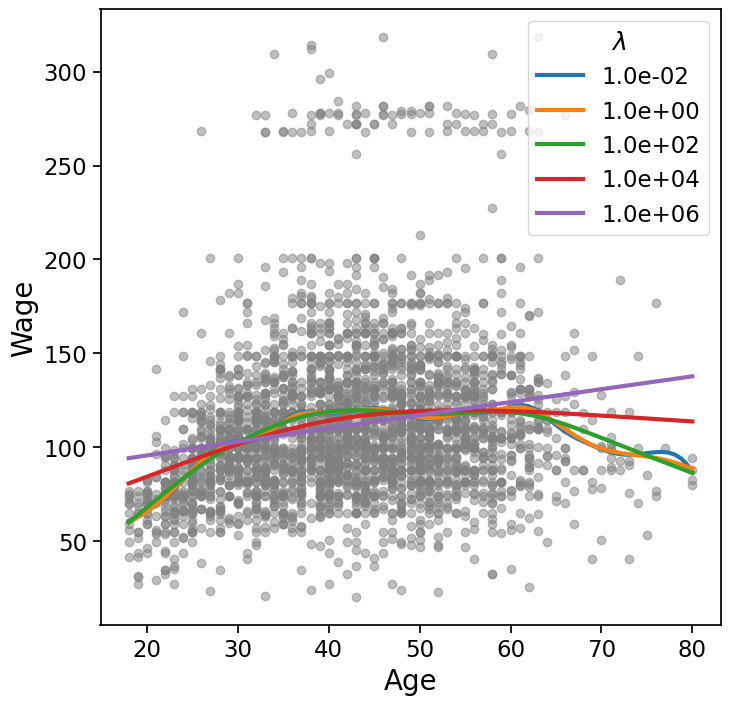

In [29]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:.1e}'.format(lam),
            linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='$\lambda$');

`pygam` 套件可以執行最佳平滑參數的搜尋。

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


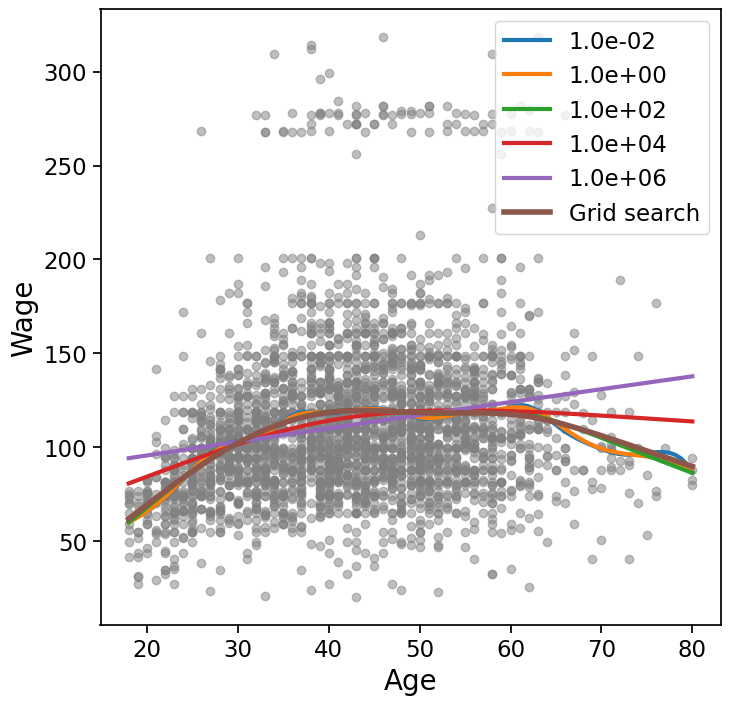

In [30]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid,
        gam_opt.predict(age_grid),
        label='Grid search',
        linewidth=4)
ax.legend()
fig

或者，我們可以使用 [`ISLP.pygam`](https://islp.readthedocs.io/en/latest/helpers/pygam.html) 套件中包含的函數來修正自由度的平滑樣條。下面我們找到能給我們大約四個自由度的 $\lambda$ 值。這裡我們需要注意，這些自由度包括平滑樣條的未懲罰截距項和線性項，因此至少有兩個自由度。

In [31]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

np.float64(4.000000100000307)

讓我們在類似上面的繪圖中變化自由度。我們選擇自由度為期望自由度加一，以說明這些平滑樣條總是具有截距項的事實。因此，`df` 值為 1 就是線性擬合。

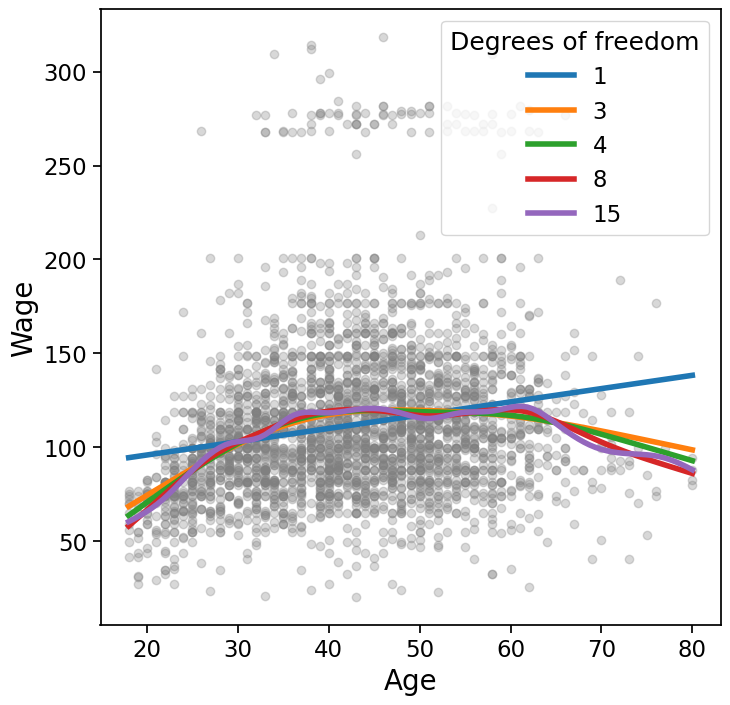

In [32]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');

### 多項式的加法模型

廣義加法模型的優勢在於它們能夠擬合比線性模型更靈活的多變數迴歸模型。我們展示兩種方法：第一種使用自然樣條和分段常數函數的較為手動方式，第二種使用 `pygam` 套件和平滑樣條。

我們現在手動擬合 GAM，使用 `year` 和 `age` 的自然樣條函數預測 `wage`，將 `education` 視為質性預測變數，如 (7.16) 所示。由於這只是一個使用適當基底函數選擇的大型線性迴歸模型，我們可以簡單地使用 `sm.OLS()` 函數來完成。

我們將在這裡以更手動的方式建構模型矩陣，因為在構造部分依賴圖時，我們希望分別存取各個部分。

In [33]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

這裡函數 [`NaturalSpline()`](https://islp.readthedocs.io/en/latest/api/generated/ISLP.transforms.html#naturalspline) 是支援 `ns()` 輔助函數的工作元件。我們選擇使用類別變數 `education` 的指示矩陣的所有欄位，這使得截距項變得冗餘。最後，我們將三個元件矩陣水平堆疊形成模型矩陣 `X_bh`。

我們現在展示如何為我們初級 GAM 中的每個項建構部分依賴圖。給定 `age` 和 `year` 的格點，我們可以手動做到這一點。我們只需使用新的 $X$ 矩陣進行預測，一次固定除一個特徵之外的所有特徵。

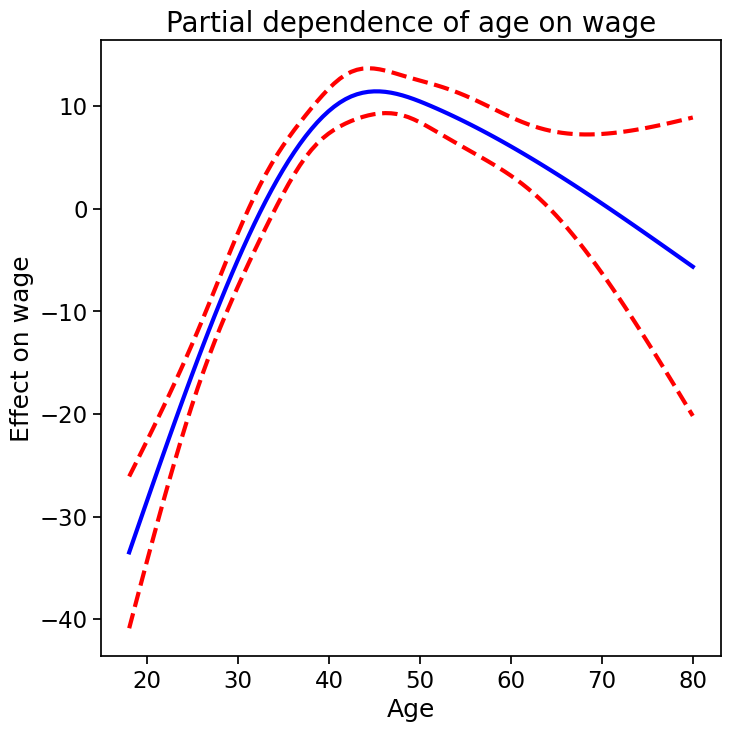

In [34]:
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

讓我們詳細解釋上面所做的事情。想法是創建一個新的預測矩陣，其中除了屬於 `age` 的欄位之外的所有欄位都是常數（並設定為它們的訓練資料均值）。`age` 的四個欄位用在 `age_grid` 中 100 個值評估的自然樣條基底填充。

* 我們在 `age` 中建立了長度為 100 的格點，並創建了一個矩陣 `X_age_bh`，它有 100 列和與 `X_bh` 相同的欄數。
* 我們將這個矩陣的每一列替換為原始矩陣的欄均值。
* 然後我們僅替換代表 `age` 的前四欄，用在 `age_grid` 中值計算的自然樣條基底。

其餘步驟現在應該已經很熟悉了。

我們也查看 `year` 對 `wage` 的影響；過程是相同的。

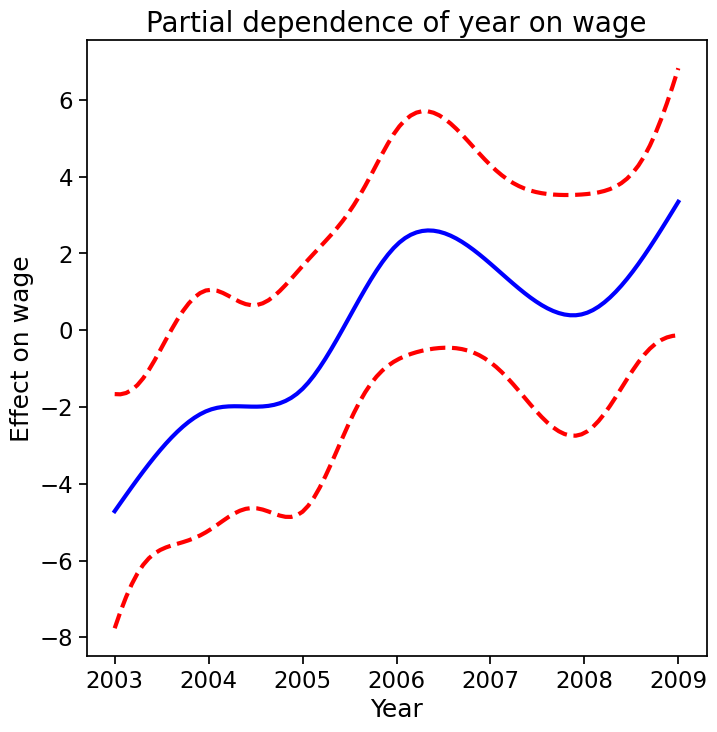

In [35]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

我們現在使用平滑樣條而不是自然樣條擬合模型 (7.16)。(7.16) 中的所有項都是同時擬合的，彼此考慮以解釋回應。`pygam` 套件僅適用於矩陣，所以我們必須將類別序列 `education` 轉換為其陣列表示，這可以透過 `education` 的 `cat.codes` 屬性找到。由於 `year` 只有 7 個唯一值，我們僅為其使用七個基底函數。

In [36]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

兩個 `s_gam()` 項結果是平滑樣條擬合，並使用 $\lambda$ 的預設值（`lam=0.6`），這在某種程度上是任意的。對於使用 `f_gam()` 項指定的類別項 `education`，我們指定 `lam=0` 以避免任何收縮。我們產生 `age` 的部分依賴圖以查看這些選擇的效果。

繪圖的值由 `pygam` 套件生成。我們在 `ISLP.pygam` 中提供了部分依賴圖的 `plot_gam()` 函數，這使得此工作比我們上一個自然樣條範例更容易。

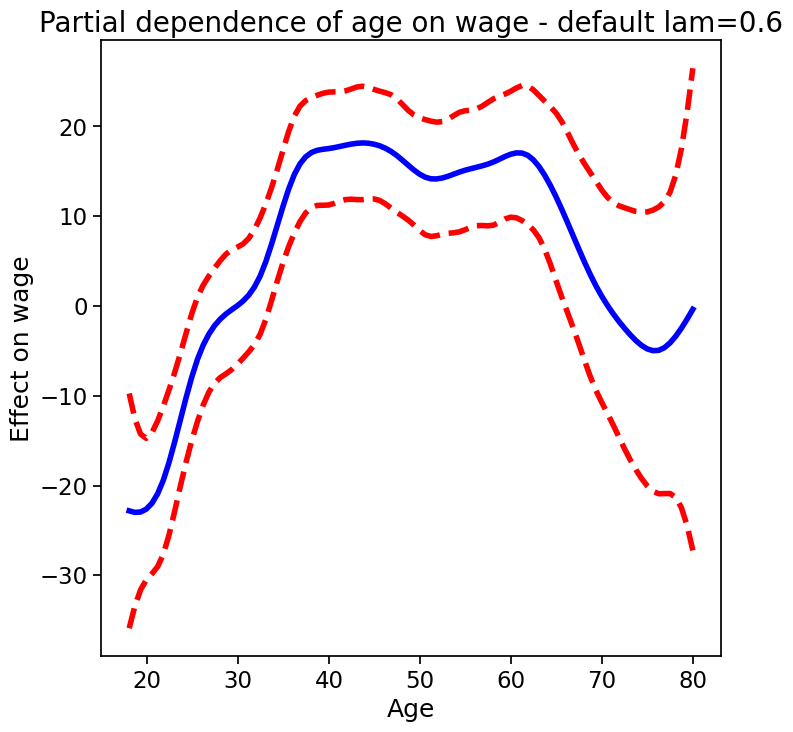

In [37]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20);

我們看到函數有些波動。指定 `df` 比 `lam` 的值更自然。我們使用 `age` 和 `year` 各四個自由度重新擬合 GAM。回憶下面加一考慮了平滑樣條的截距項。

In [38]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

注意：上面更新 `age_term.lam` 也會更新 `gam_full.terms[0]` 中的！`year_term.lam` 同樣如此。

重複 `age` 的圖，我們看到它更平滑了。我們也製作 `year` 的圖。

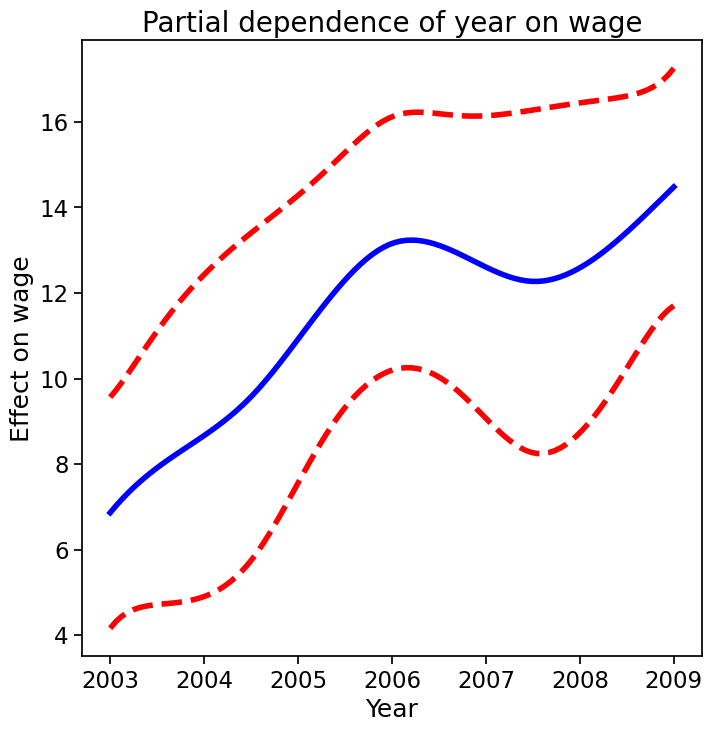

In [39]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);

最後我們繪製 `education`，它是類別的。部分依賴圖是不同的，更適合這個變數的每個層級的擬合常數集合。

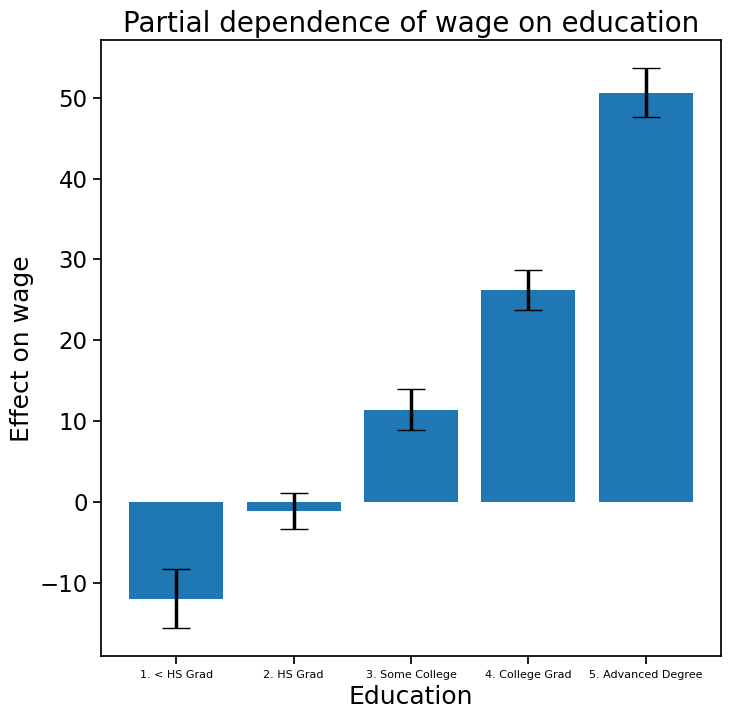

In [40]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

### 加法模型的 ANOVA 檢定

在我們所有模型中，`year` 函數看起來相當線性。我們可以執行一系列 ANOVA 檢定以確定這三個模型中哪一個最好：排除 `year` 的 GAM（$\mathcal{M}_1$）、使用 `year` 線性函數的 GAM（$\mathcal{M}_2$），或使用 `year` 樣條函數的 GAM（$\mathcal{M}_3$）。

In [41]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term +
                       l_gam(1, lam=0) +
                       f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

注意我們在上面表達式中使用 `age_term`。我們這樣做是因為之前我們在這個項中設定了 `lam` 的值以達到四個自由度。

為了直接評估 `year` 的效應，我們對上面擬合的三個模型執行 ANOVA。

我們發現有令人信服的證據表明，`year` 中具有線性函數的 GAM 比完全不包括 `year` 的 GAM 更好（p 值 = 0.002）。然而，沒有證據表明需要 `year` 的非線性函數（p 值 = 0.435）。換句話說，基於這個 ANOVA 的結果，$\mathcal{M}_2$ 是首選的。

我們也可以對 `age` 重複相同的過程。我們看到有非常明確的證據表明 `age` 需要非線性項。

In [42]:
gam_0 = LinearGAM(year_term +
                  f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) +
                       year_term +
                       f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


GAM 擬合有一個（冗長的）`summary()` 方法。

In [43]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/tmp/ipython-input-3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


我們可以從 `gam` 物件進行預測，就像從 `lm` 物件一樣，使用類別 `gam` 的 `predict()` 方法。這裡我們在訓練集上進行預測。

In [44]:
Yhat = gam_full.predict(Xgam)

為了擬合邏輯迴歸 GAM，我們使用 `pygam` 的 `LogisticGAM()`。

In [45]:
gam_logit = LogisticGAM(age_term +
                        l_gam(1, lam=0) +
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

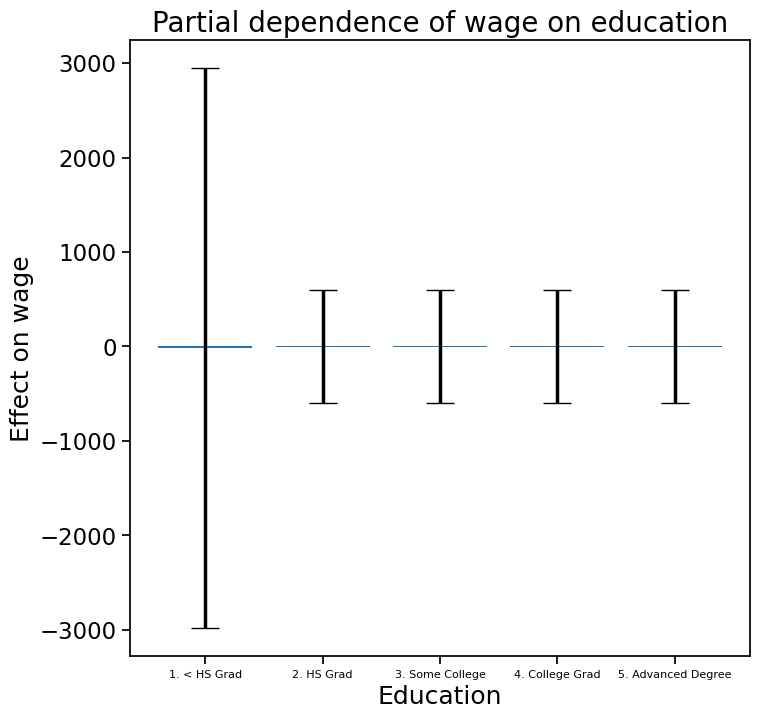

In [46]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

模型看起來非常平坦，特別是第一個類別的誤差條很高。讓我們更仔細地查看資料。

In [47]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


我們看到第一個教育類別中沒有高收入者，這意味著模型將很難擬合。我們將擬合邏輯迴歸 GAM，排除所有屬於這個類別的觀測。這提供了更合理的結果。

為此，我們可以對模型矩陣進行子集，但這不會從 `Xgam` 中移除該欄。雖然我們可以推斷哪個欄對應於這個特徵，但為了重現性，我們在這個較小的子集上重新形成模型矩陣。

In [48]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'],
                         Wage_['year'],
                         Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']

在上面倒數第二行中，我們從類別的編碼中減去一，這是由於 `pygam` 的一個錯誤。它只是重新標記教育值，因此對擬合沒有影響。

我們現在擬合模型。

In [49]:
gam_logit_ = LogisticGAM(age_term +
                         year_term +
                         f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

現在我們已經移除了這些觀測，讓我們查看 `education`、`year` 和 `age` 對高收入者狀態的影響。

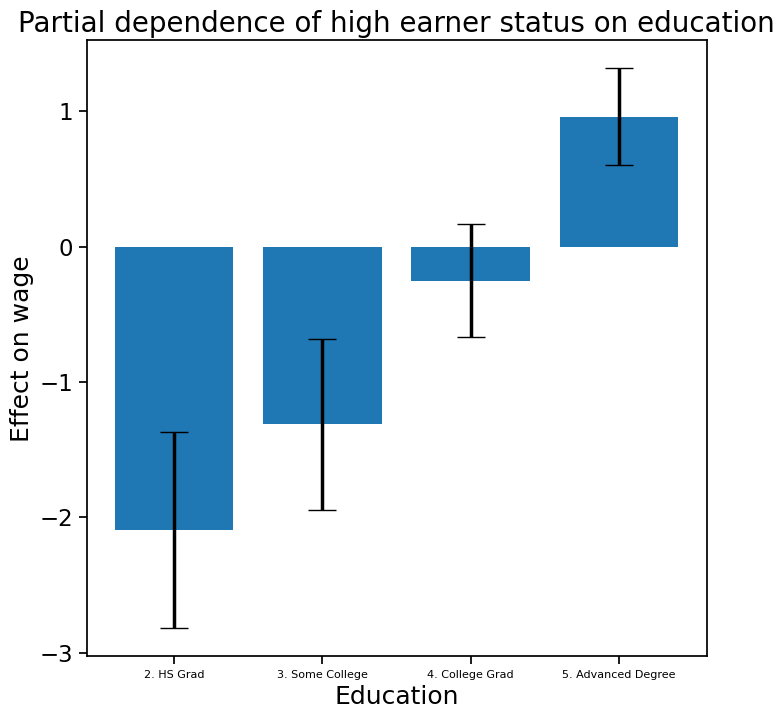

In [50]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on education', fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories[1:],
                   fontsize=8);

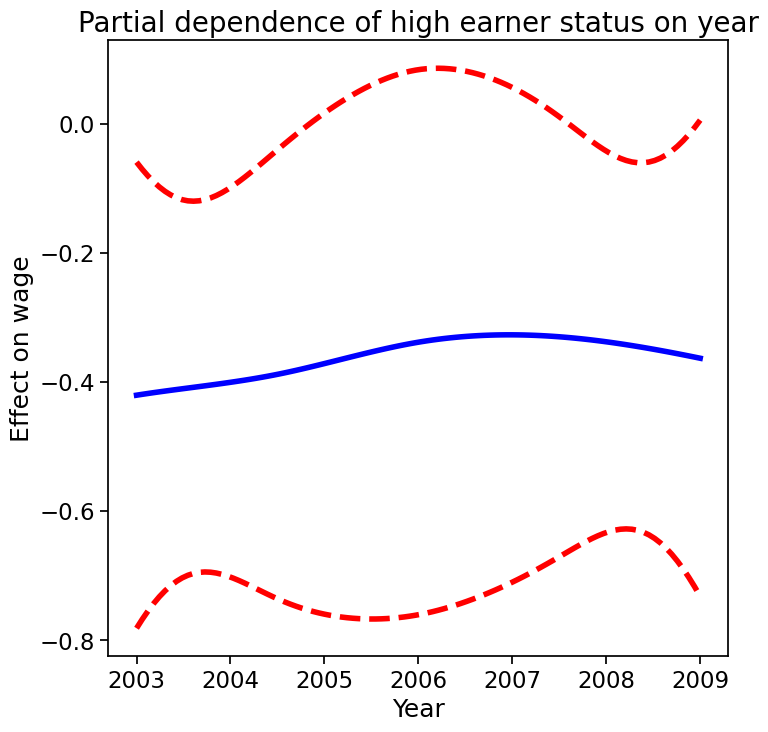

In [51]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on year',
             fontsize=20);

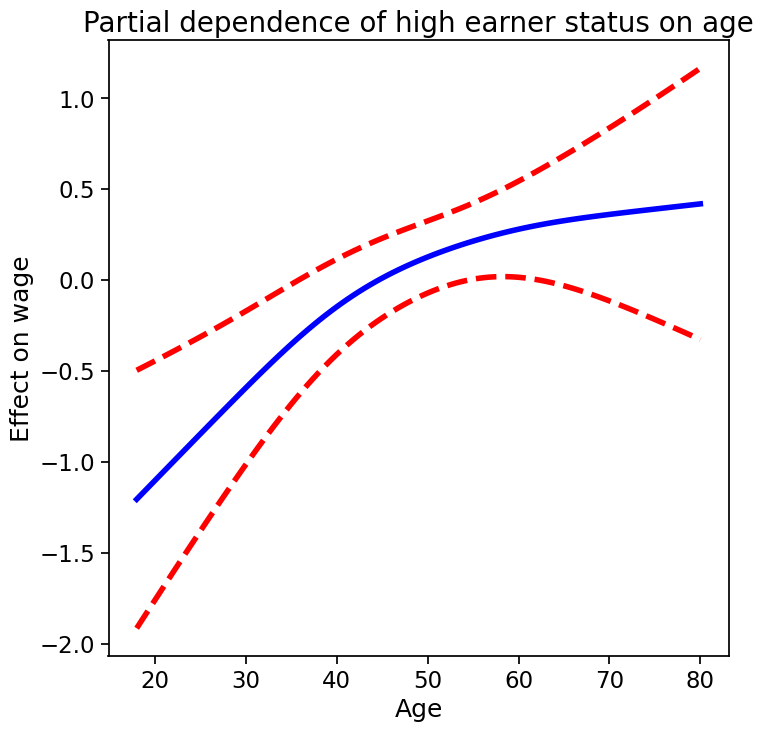

In [52]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of high earner status on age', fontsize=20);

### 直接使用 `pyGAM`

In [53]:
Wage['education'] = Wage['education'].map({'1. < HS Grad': 0.0,
                                                 '2. HS Grad': 1.0,
                                                 '3. Some College': 2.0,
                                                 '4. College Grad': 3.0,
                                                 '5. Advanced Degree': 4.0
                                                })

In [54]:
X = Wage[['year','age','education']]
y = Wage['wage']

In [56]:
## model where s means penalized B-spline and f is the factor term
gam = LinearGAM(s_gam(0) + s_gam(1) + f_gam(2))
gam.gridsearch(X.to_numpy(), y.values)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 640x480 with 0 Axes>

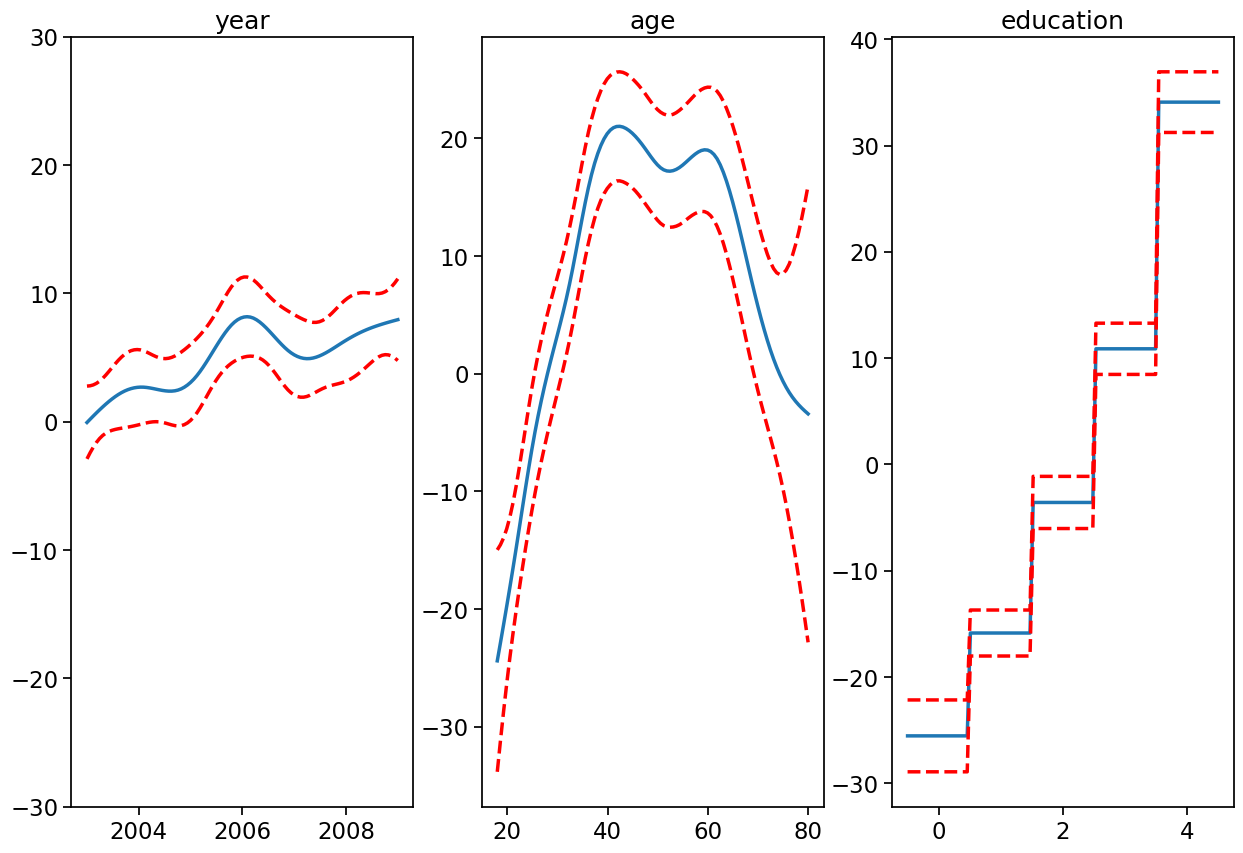

In [57]:
## plotting
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,10))

titles = ['year', 'age', 'education']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    sns.lineplot(x=XX[:, i], y=gam.partial_dependence(term=i, X=XX), ax=ax);
    sns.lineplot(x=XX[:, i], y=gam.partial_dependence(term=i, X=XX,  width=.95)[1][:,0], ls='--', ax=ax, color='red');
    sns.lineplot(x=XX[:, i], y=gam.partial_dependence(term=i, X=XX,  width=.95)[1][:,1], ls='--', ax=ax, color='red');
    if i == 0:
        ax.set_ylim(-30,30);
    ax.set_title(titles[i]);

In [58]:
gam.summary() #Even though our model allows coefficients, our smoothing penalty reduces us to just 19 effective degrees of freedom

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2602
Link Function:                     IdentityLink Log Likelihood:                                -24116.7451
Number of Samples:                         3000 AIC:                                            48274.0106
                                                AICc:                                           48274.2998
                                                GCV:                                             1250.3656
                                                Scale:                                           1235.9245
                                                Pseudo R-Squared:                                   0.2945
Feature Function                  Lam

/tmp/ipython-input-860454494.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary() #Even though our model allows coefficients, our smoothing penalty reduces us to just 19 effective degrees of freedom


使用 `LogisticGAM` 進行分類

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


<Figure size 640x480 with 0 Axes>

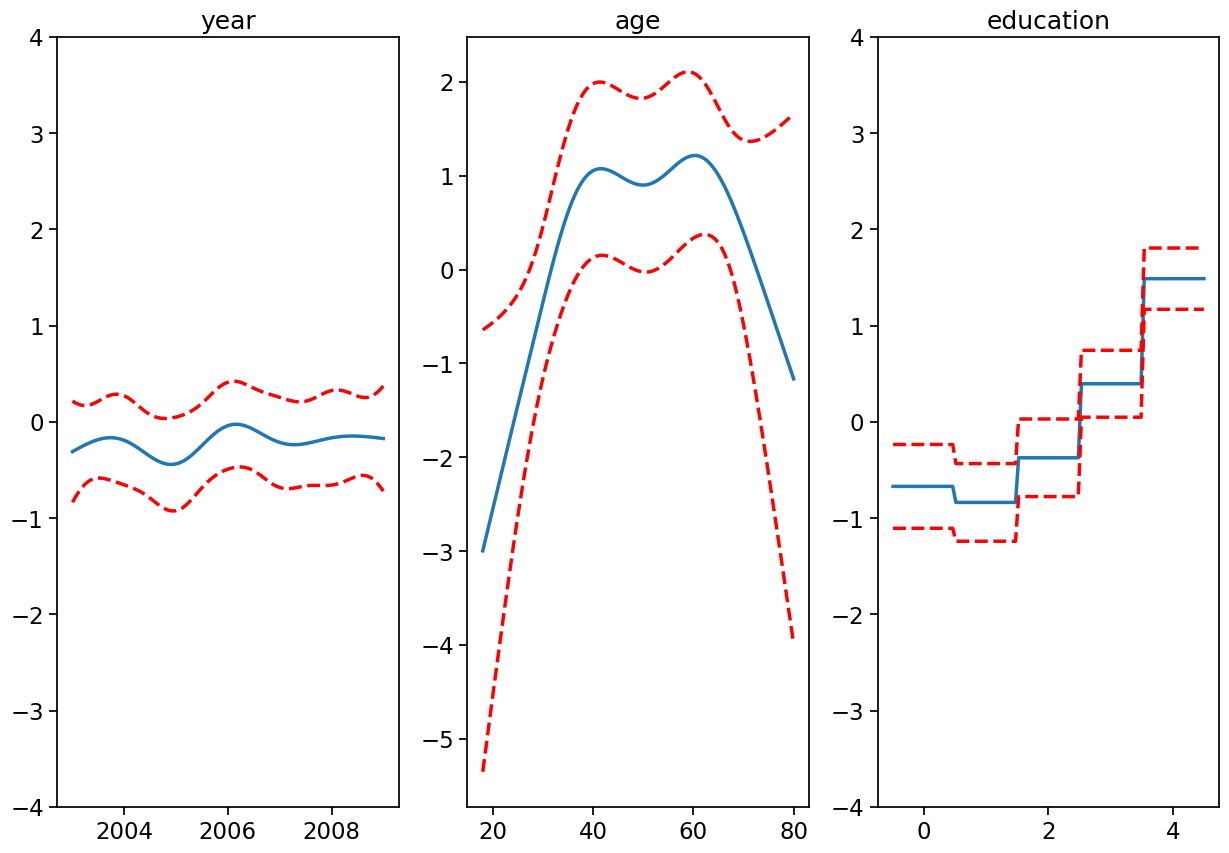

In [59]:
Wage['wage_binary'] = np.where(Wage['wage']>250,1,0)
y = Wage['wage_binary']

gam = LogisticGAM(s_gam(0) + s_gam(1) + f_gam(2)).gridsearch(X.to_numpy(), y.values)

plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,10))

titles = ['year', 'age', 'education']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i])
    if i == 0:
        ax.set_ylim(-4,4)
    elif i==2:
        ax.set_ylim(-4,4)

## 區域回歸

我們使用 `sm.nonparametric` 中的 [`lowess()`](https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) 函數來說明區域回歸的使用。某些 GAM 實作允許項目成為區域回歸運算子；這在 `pygam` 中並非如此。

在這裡我們擬合使用跨度 0.2 和 0.5 的區域線性回歸模型；也就是說，每個鄰域由 20% 或 50% 的觀測值組成。如預期的那樣，使用跨度 0.5 比 0.2 更平滑。

In [60]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

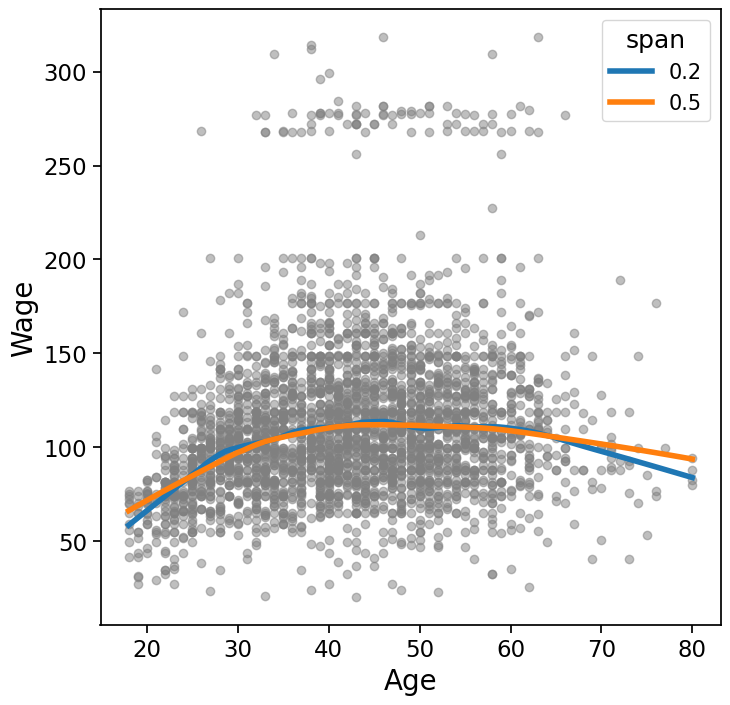

In [61]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y,
                    age,
                    frac=span,
                    xvals=age_grid)
    ax.plot(age_grid,
            fitted,
            label='{:.1f}'.format(span),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='span', fontsize=15);